### Анализ базы вакансий

Цель: *Выявить различия между вакансиями DA и DS*

Этапы:
- Предобработка данных.
- Исследовательский анализ данных.
    - Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Специалист по Data Science.
    -  Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Специалист по Data Science по следующим параметрам: самые важные hard-skils, самые важные soft-skils.
    -  Определение типичного места работы для Аналитика данных и специалист по Data Science по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы.
    -  Расчет помесячной динамики количества вакансий для Аналитика данных и специалиста по Data Science.
-  Формулирование выводов и рекомендаций.
-  Создание презентации.
 

**Загрузка и предобработка данных**

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [2]:
pio.renderers.default='jpg'


In [3]:
try:
    da = pd.read_excel(r'Downloads/vacancies_da (2).xlsx')
    ds = pd.read_excel(r'Downloads/vacancies_ds.xlsx')
except:
    da = pd.read_excel('vacancies_da.xlsx')
    ds = pd.read_excel('vacancies_ds.xlsx')

In [4]:
da['analytics_type'] = 'da'
ds['analytics_type'] = 'ds'

In [5]:
print(f'Минимальная дата размещения вакансии DA: {da['published_at'].min()}')
print(f'Максимальная дата размещения вакансии DA: {da['published_at'].max()}')

Минимальная дата размещения вакансии DA: 2024-03-06 08:13:00
Максимальная дата размещения вакансии DA: 2024-04-30 12:51:55


In [6]:
print(f'Минимальная дата размещения вакансии DS: {ds['published_at'].min()}')
print(f'Максимальная дата размещения вакансии DS: {ds['published_at'].max()}')

Минимальная дата размещения вакансии DS: 2024-02-29 15:01:35
Максимальная дата размещения вакансии DS: 2024-04-30 11:41:03


In [7]:
# Обьединение датафреймов, удаление дубликатов и ненужного столбца.

vacancies = pd.concat([da, ds])

rows_v = len(vacancies)

vacancies = vacancies.drop(columns = 'type')

vacancies = vacancies.drop_duplicates(subset = ['schedule', 
                                                'name',
                                                'description',
                                                'employer',
                                                'key_skills_from_key_skills_field'],
                                     keep='last').reset_index(drop=True)

In [8]:
print(f'Доля удаленных дубликатов: {round((1 - (len(vacancies) / rows_v)) * 100, 2)}%')

Доля удаленных дубликатов: 14.4%


In [9]:
vacancies.salary_to.describe()

count        65.000000
mean     262291.538462
std      116072.144715
min       30000.000000
25%      200000.000000
50%      250000.000000
75%      350000.000000
max      550000.000000
Name: salary_to, dtype: float64

In [10]:
vacancies.salary_from.describe()

count        75.000000
mean     165812.666667
std       72506.045458
min       25000.000000
25%      110000.000000
50%      150000.000000
75%      200000.000000
max      350000.000000
Name: salary_from, dtype: float64

In [11]:
rows_v, len(vacancies), len(vacancies.query('analytics_type=="da"')), len(vacancies.query('analytics_type=="ds"')) 

(972, 832, 264, 568)

In [12]:
vacancies.experience = vacancies.experience.replace(
    {'Junior+ (1-3 years)' : 'J+',
     'Middle (3-6 years)' : 'M',
     'Junior (no experince)' : 'J',
     'Senior (6+ years)' : 'S'})

Итоги по предобработке и проверке данных
-  Удалены столбцы не имеющие для нас ценности
-  Данные имеют правильные типы данных
-  В данных отсуствуют аномальные значения 
-  Объединение таблиц позволило выявить и удалить 14.4% дубликатов

In [13]:
experience_group = vacancies.groupby(by=['analytics_type', 'experience'])['id'].agg('count')

experience_group = experience_group.reset_index()

experience_group['cnt'] = np.where(experience_group['analytics_type']=='da',experience_group.query('analytics_type == "da"')['id'].sum(), experience_group.query('analytics_type == "ds"')['id'].sum())

experience_group['percent_of_type'] = round((experience_group['id'] / experience_group['cnt']) * 100, 1)

experience_group.columns = ['type', 'grade', 'cnt', 'total', 'percent_of_type']

In [14]:
experience_group

,type,grade,cnt,total,percent_of_type
0,da,J,8,264,3.0
1,da,J+,149,264,56.4
2,da,M,104,264,39.4
3,da,S,3,264,1.1
4,ds,J,25,568,4.4
5,ds,J+,238,568,41.9
6,ds,M,283,568,49.8
7,ds,S,22,568,3.9


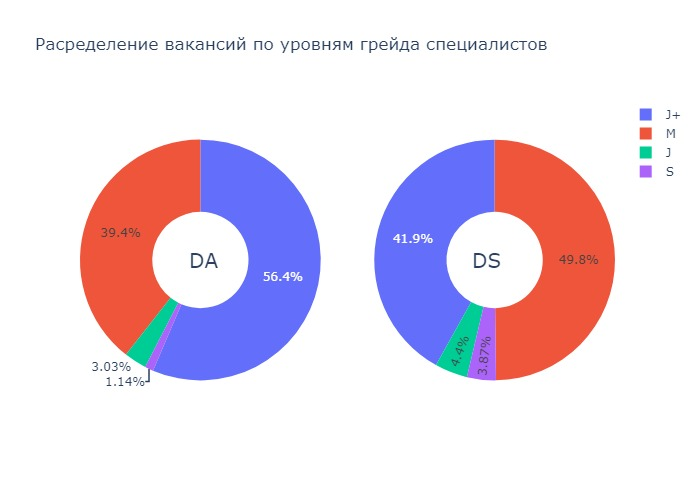

In [15]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels = experience_group.query('type == "da"')['grade'], 
                     values = experience_group.query('type == "da"')['cnt'],
                     hole = .4,
                     name = 'DA'), 1, 1)
fig.add_trace(go.Pie(labels = experience_group.query('type == "ds"')['grade'], 
                     values = experience_group.query('type == "ds"')['cnt'],
                     hole = .4,
                     name = 'DS'), 1, 2)
fig.update_layout(title_text = 'Расределение вакансий по уровням грейда специалистов',
                 annotations=[dict(text='DA', x=0.20, y=0.5, font_size=20, showarrow=False),
                              dict(text='DS', x=0.79, y=0.5, font_size=20, showarrow=False)])
fig.show()

**Доли грейдов среди профессий DA и DS**
- Среди ваканский DA, на Junior+ и Middle специалистов приходится 95.9% всех ваканский, из которых основной спрос приходится на J+. Вакансии для Junior и Senior специалистов встречаются крайне редко.
- С вакансиями DS специалистов, ситуация очень схожа с DA, но здесь основную долю забрали M специалисты, a J+ встречаются на 8% реже, а так же немного чаще требуют S специаистов.
- Кол-во ваканский DS больше чем в 2 раза вакансий DA

In [16]:
vacancies.head(1)

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,analytics_type
0,82978778,Data analyst,2024-04-09 10:29:02,https://hh.ru/vacancy/82978778,Телеком биржа,NaN,Москва,J+,"['HTTP', 'Pandas', 'Linux', 'Git', 'Clickhouse...",Полный день,Полная занятость,"кто мы: servicepipe - команда айтишников, кото...",servicepipe команда айтишник работать рынок иб...,NaN,NaN,ЗП не указана,"SQL, Математическая статистика, Linux, Clickho...",Pandas,NaN,da


In [17]:
def get_skills(analytic_type, skills_from, experience):
    skills = vacancies.query('analytics_type==@analytic_type & experience==@experience')[skills_from]
    skills = skills.dropna()
    counter_skills = {}
    
    for skills_row in skills:
        skills = skills_row.split(', ')
        for skill in skills:
            counter_skills[skill] = counter_skills.get(skill, 0) + 1
            
    counter_skills = {k: v for k,v in sorted(counter_skills.items(), key=lambda item: item[1], reverse=True) if v > 5}
    return counter_skills

In [18]:
# Получаем лист с грейдами
grade_list = list(vacancies.experience.unique())

# Создаем пустой DF
da_frame = pd.DataFrame

# Создаем датафреймы для каждого грейда в которые войдут самые популярные скиллы
da_soft_skills = {grade: pd.DataFrame(get_skills('da', 'soft_skills_from_description', grade).items(), columns=['skill', 'cnt']) for grade in grade_list }
ds_soft_skills = {grade: pd.DataFrame(get_skills('ds', 'soft_skills_from_description', grade).items(), columns=['skill', 'cnt']) for grade in grade_list }

da_hard_skills = {grade: pd.DataFrame(get_skills('da', 'hard_skills_from_description', grade).items(), columns=['skill', 'cnt']) for grade in grade_list }
ds_hard_skills = {grade: pd.DataFrame(get_skills('ds', 'hard_skills_from_description', grade).items(), columns=['skill', 'cnt']) for grade in grade_list }

# Добавляем для каждого датафрейма поле с типом грейда
for name, df in da_soft_skills.items():
    df['type'] = name
for name, df in ds_soft_skills.items():
    df['type'] = name

for name, df in da_hard_skills.items():
    df['type'] = name
for name, df in ds_hard_skills.items():
    df['type'] = name

# Обьеденяем таблицы
da_soft = pd.concat(da_soft_skills.values())
ds_soft = pd.concat(ds_soft_skills.values())

da_hard = pd.concat(da_hard_skills.values())
ds_hard = pd.concat(ds_hard_skills.values())

soft_da_ds = pd.concat([da_soft, ds_soft], keys=['da', 'ds'], join='inner').reset_index().drop(columns='level_1')
hard_da_ds = pd.concat([da_hard, ds_hard], keys=['da', 'ds'], join='inner').reset_index().drop(columns='level_1')

soft_da_ds.columns = ['type', 'skill', 'cnt', 'grade']
hard_da_ds.columns = ['type', 'skill', 'cnt', 'grade']

In [19]:
soft_da_ds

,type,skill,cnt,grade
0,da,Документация,20,J+
1,da,Коммуникация,18,J+
2,da,Аналитическое мышление,7,J+
3,da,Документация,18,M
4,da,Коммуникация,14,M
5,ds,Документация,38,J+
6,ds,Коммуникация,22,J+
7,ds,Аналитическое мышление,7,J+
8,ds,Документация,47,M
9,ds,Коммуникация,39,M


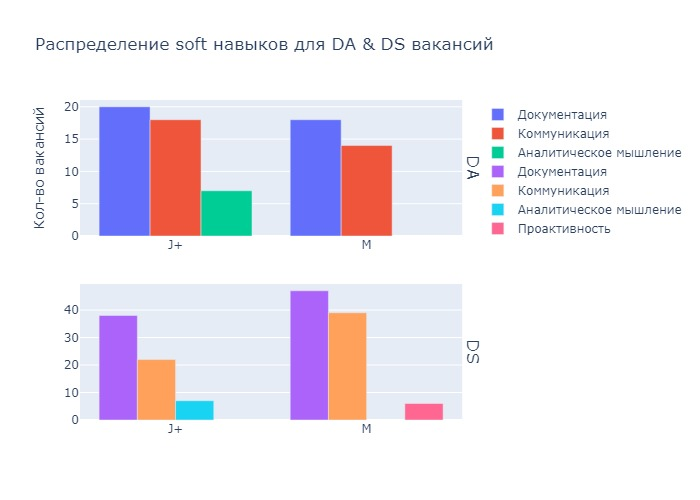

In [20]:
fig = make_subplots(rows=2, cols=1, row_titles=['DA', 'DS'])
for skill in soft_da_ds.query('type=="da"')['skill'].unique():
    dfp = soft_da_ds.query('type=="da" & skill==@skill')
    fig.add_traces(go.Bar(x=dfp['grade'], y = dfp['cnt'], name=skill), rows=1,cols=1)
    
for skill in soft_da_ds.query('type=="ds"')['skill'].unique():
    dfp = soft_da_ds.query('type=="ds" & skill==@skill')
    fig.add_traces(go.Bar(x=dfp['grade'], y = dfp['cnt'], name=skill), rows=2,cols=1)
    
fig.update_layout(title_text = 'Распределение soft навыков для DA & DS вакансий',
                 yaxis_title='Кол-во вакансий')
fig.show()

**SoftSkills**
- DA: Наиболее важные софт скиллы для J+ и M это документация и коммуникация. А для J+ так же добавляется аналитическое мышление.
- DS: Такая же ситуация складывается с DS специалистами тех же грейдов. Разница тольков в возросшем требовании к документации у специалистов J+

In [21]:
hard_da_ds

,type,skill,cnt,grade
0,da,Pandas,37,J+
1,da,confluence,12,J+
2,da,Pandas,22,M
3,da,confluence,11,M
4,ds,Pandas,106,J+
5,ds,Юнит-экономика,22,J+
6,ds,confluence,22,J+
7,ds,Pandas,89,M
8,ds,confluence,22,M
9,ds,Юнит-экономика,18,M


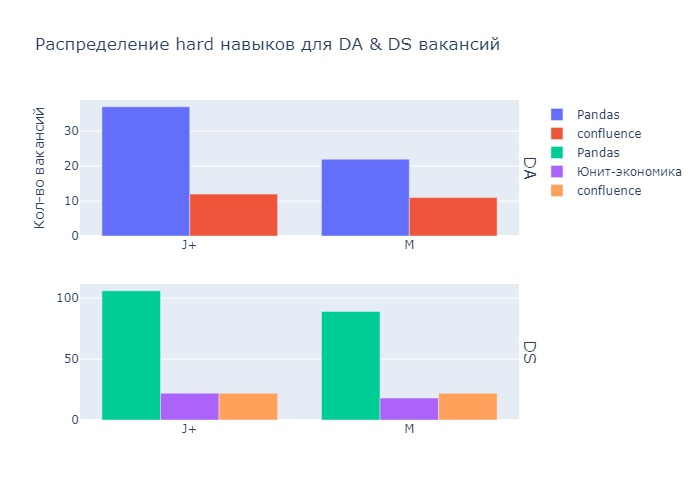

In [22]:
fig = make_subplots(rows=2, cols=1, row_titles=['DA', 'DS'])
for skill in hard_da_ds.query('type=="da"')['skill'].unique():
    dfp = hard_da_ds.query('type=="da" & skill==@skill')
    fig.add_traces(go.Bar(x=dfp['grade'], y = dfp['cnt'], name=skill), rows=1,cols=1)
    
for skill in hard_da_ds.query('type=="ds"')['skill'].unique():
    dfp = hard_da_ds.query('type=="ds" & skill==@skill')
    fig.add_traces(go.Bar(x=dfp['grade'], y = dfp['cnt'], name=skill), rows=2,cols=1)
    
fig.update_layout(title_text = 'Распределение hard навыков для DA & DS вакансий',
                 yaxis_title='Кол-во вакансий')
fig.show()

**HardSkills**
- Для обоих специальностей основное требование по hard скиллу является pandas. Дополнительные менее важные скилы для двух направлений, являются confluence. Для DA специалистов его просят чаще. Особенно это заметно на M гредовых вакансиях.
- DS специалисты заточены на работу с большими данными поэтому основной упор идет на хард скилл pandas

In [23]:
vacancies.query('analytics_type == "da"').employer.value_counts().head().reset_index()

,employer,count
0,СБЕР,55
1,WILDBERRIES,13
2,МТС,7
3,"МАГНИТ, Розничная сеть",5
4,«UZUM TECHNOLOGIES».,5


In [24]:
vacancies.query('analytics_type == "ds"').employer.value_counts().head().reset_index()

,employer,count
0,СБЕР,122
1,Ozon,18
2,Samokat.tech,16
3,Банк ВТБ (ПАО),12
4,Lamoda Tech,9


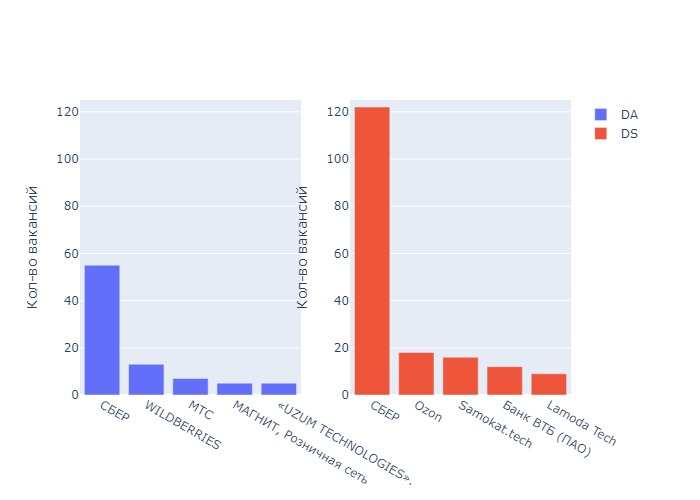

In [25]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Bar(x = vacancies.query('analytics_type == "da"').employer.value_counts().head().reset_index().employer,
                     y = vacancies.query('analytics_type == "da"').employer.value_counts().head().reset_index()['count'], name = 'DA'),1,1)

fig.add_trace(go.Bar(x = vacancies.query('analytics_type == "ds"').employer.value_counts().head().reset_index().employer,
                     y = vacancies.query('analytics_type == "ds"').employer.value_counts().head().reset_index()['count'], name = 'DS'),1,2)

fig.update_yaxes(range=[0, 125], title='Кол-во вакансий')  

fig.show()

**Работодатели DA и DS**

Для данных специальностей можно выделить одного ведущего работодателя 
- СБЕР

В обоих случая работодателями являются банки и интернет магазины.

In [26]:
salary_group = vacancies.groupby(by=['analytics_type', 'experience'])[['salary_from', 'salary_to']].agg(['count','mean'])
salary_group = salary_group.reset_index()
salary_group.columns =['analytics_type', 'experience', 'cnt_from', 'avg_salary_from', 'cnt_to', 'avg_salary_to']
salary_group

,analytics_type,experience,cnt_from,avg_salary_from,cnt_to,avg_salary_to
0,da,J,1,60000.000000,0,NaN
1,da,J+,19,142684.210526,14,182928.571429
2,da,M,7,238064.285714,8,372975.000000
3,da,S,0,NaN,0,NaN
4,ds,J,2,47500.000000,1,80000.000000
5,ds,J+,20,134650.000000,17,227058.823529
6,ds,M,25,202020.000000,22,296552.272727
7,ds,S,1,160000.000000,3,346666.666667


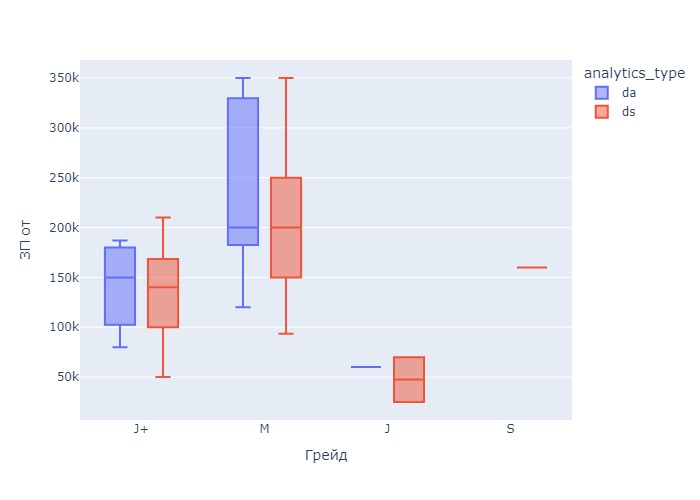

In [27]:
fig = px.box(vacancies, x = 'experience', y = 'salary_from', color = 'analytics_type')
fig.update_layout(xaxis_title = 'Грейд',
                 yaxis_title = 'ЗП от')
fig.show()

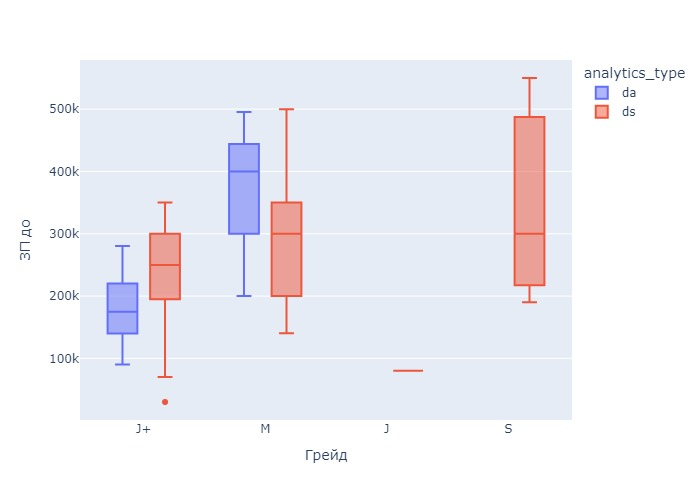

In [28]:
fig = px.box(vacancies, x = 'experience', y = 'salary_to', color = 'analytics_type')
fig.update_layout(xaxis_title = 'Грейд',
                 yaxis_title = 'ЗП до')

fig.show()

**Заработная плата DA & DS специалистов**

*Средняя начальная ЗП*
- У DS специалистов больший разброс среди начальной ЗП, но медианное значение точно совпадает с DA
  
*Средняя пиковая ЗП*
- DS специалисты могут расчитывать на более высокую максимальную зп среди J+ специалистов, а среди M специалистов по максимальному доходу выходят вперед DA специалисты.

*На данный момент мы имеем небольшое кол-во наблюдений и данные выводы могут измениться при добавлении новых.*

In [29]:
vacancies.groupby(['analytics_type', 'experience'])['employment'].value_counts().reset_index()

,analytics_type,experience,employment,count
0,da,J,Полная занятость,8
1,da,J+,Полная занятость,149
2,da,M,Полная занятость,103
3,da,M,Частичная занятость,1
4,da,S,Полная занятость,3
5,ds,J,Полная занятость,13
6,ds,J,Стажировка,12
7,ds,J+,Полная занятость,236
8,ds,J+,Проектная работа,1
9,ds,J+,Частичная занятость,1


**Тип занятости**
- Практически все вакансии требуют полную занятость. А J DS специалисты разделились на полную занятость и стажировку

In [30]:
vacancies.groupby(['analytics_type', 'experience'])['schedule'].value_counts().reset_index().query('count > 5')

,analytics_type,experience,schedule,count
0,da,J,Полный день,7
2,da,J+,Полный день,109
3,da,J+,Удаленная работа,33
6,da,M,Полный день,75
7,da,M,Удаленная работа,27
11,ds,J,Полный день,18
14,ds,J+,Полный день,181
15,ds,J+,Удаленная работа,49
16,ds,J+,Гибкий график,7
18,ds,M,Полный день,221


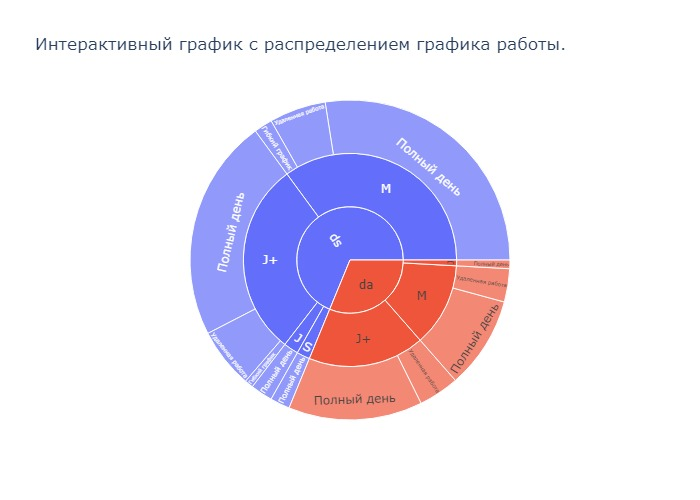

In [31]:
fig = px.sunburst(data_frame = vacancies.groupby(['analytics_type', 'experience'])['schedule'].value_counts().reset_index().query('count > 5'),
                names = 'schedule',
                values = 'count',
                path = ['analytics_type','experience','schedule'],
                title = 'Интерактивный график с распределением графика работы.')

fig.show()

In [32]:
print(f'Доля вакансий с удаленной работой: {round(len(vacancies.query('schedule == "Удаленная работа"')) * 100  / rows_v, 1)}%')

Доля вакансий с удаленной работой: 16.6%


In [33]:
print(f'Доля вакансий с полным днем: {round(len(vacancies.query('schedule == "Полный день"')) * 100  / rows_v, 1)}%')

Доля вакансий с полным днем: 64.7%


**График работы**
- 65% всех вакансий - это полный день и 16% - это удаленная работа
- Распределение среди DA и DS специалистов примерно равное. Погрешность списывается на разность масштаба выборок.

In [34]:
vacancies['year_month'] = vacancies.published_at.dt.to_period('M')
vacancies['year_week'] = vacancies.published_at.dt.isocalendar().week


In [35]:
dynamic_month = vacancies.groupby(['analytics_type','experience', 'year_month'])['id'].count().reset_index().sort_values(by=['analytics_type','experience', 'year_month'])
dynamic_month['total'] = dynamic_month.query('analytics_type=="da"')['id'].sum()
dynamic_month.loc[dynamic_month['analytics_type']=='ds', 'total'] = dynamic_month.query('analytics_type == "ds"')['id'].sum()
dynamic_month['percent_of_total'] = round(dynamic_month.id * 100 / dynamic_month.total, 1)
dynamic_month

,analytics_type,experience,year_month,id,total,percent_of_total
0,da,J,2024-03,1,264,0.4
1,da,J,2024-04,7,264,2.7
2,da,J+,2024-03,29,264,11.0
3,da,J+,2024-04,120,264,45.5
4,da,M,2024-03,26,264,9.8
5,da,M,2024-04,78,264,29.5
6,da,S,2024-04,3,264,1.1
7,ds,J,2024-03,12,568,2.1
8,ds,J,2024-04,13,568,2.3
9,ds,J+,2024-03,69,568,12.1


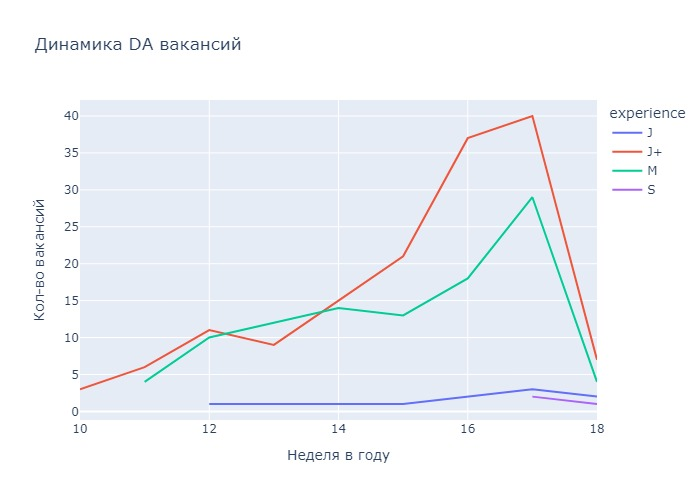

In [36]:
fig = px.line(vacancies.query('analytics_type=="da"').groupby(['experience', 'year_week'])['id'].count().reset_index().sort_values(by=['experience', 'year_week']),
             x='year_week',
             y='id', color='experience',
             title = 'Динамика DA вакансий')
fig.update_layout(xaxis_title='Неделя в году',
                 yaxis_title='Кол-во вакансий')
fig.show()

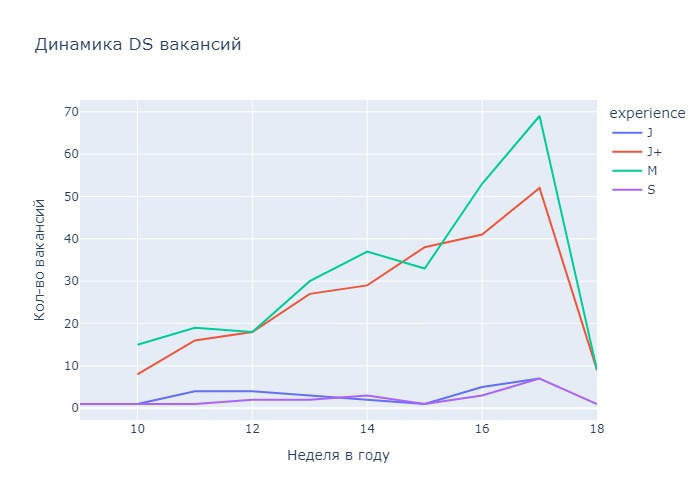

In [37]:
fig = px.line(vacancies.query('analytics_type=="ds"').groupby(['experience', 'year_week'])['id'].count().reset_index().sort_values(by=['experience', 'year_week']),
             x='year_week',
             y='id', color='experience',
             title = 'Динамика DS вакансий')

fig.update_layout(xaxis_title='Неделя в году',
                 yaxis_title='Кол-во вакансий')
fig.show()

**Динамика кол-ва вакансий**
- Среди DA и DS специалистов, повышается спрос на J+ & M уровневых специалистов.
- Среди DA вакансий, больший рост показывает J+, а среди DS - M

**Общий вывод**

Вакансии DA & DS специалистов очень схожи, но имеют различные тенденции.
- Если DA ищут в основном крепких джунов, то DS ищут более опытных специалистов. В основном это M уровень
- DS Ищут практически с тем же наборов скиллов, но требуют чаще навыки работы с большими.
- Разницу в ЗП можно заметить из-за разброса значений, но медианное значение начальной ЗП показывает практически равные значения, а максимальная ЗП передает эстафету: среди J+ лидируют DS, а среди M  лидируют DA специалисты. Но кол-во наблюдений слишком мало для того чтобы с уверенностью заявить, что DA специалисты с грейдом М могут расчитывать на более высокую ЗП.
- По данным за данный период можно сказать что DA и DS специалисты, в основном работают в банках и винтернет магазинах. Они имеют полную занятость и в большей части графиком работы является полный день т.е. работают в офисе.

После проведения данного исследования удалось выявить что данные специальности имеют очень много схожих показателей, но кол-во вакансий для DS гораздо выше. Ищут в основном J+ & M уровневых специалистов. Кол-во новых вакансий увеличивается с каждым месяцем, но следует продолжать наблюдения т.к. мы имеем данные всего за 2 месяца и при повышении кол-ва наблюдейний, показатели могут измениться.

[Презентация](https://docs.google.com/presentation/d/1QqV6HLx0MEvaK0VP6ZgnPseiALnTn5eSnmJYQNk652w/edit?usp=sharing)